# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil
Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [25]:
! pip install Pillow

In [26]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable

import torchvision

## Carregamento dos dados do MNIST

In [27]:
! git clone https://github.com/vcasadei/MNIST.git

fatal: destination path 'MNIST' already exists and is not an empty directory.


In [28]:
!ls MNIST

processed  raw


In [29]:
dataset_dir = 'MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [30]:
x_train = x_train.float()

x_train = x_train / 255.

if False:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(np.float64(-0.5), np.float64(232.5), np.float64(87.5), np.float64(-0.5))

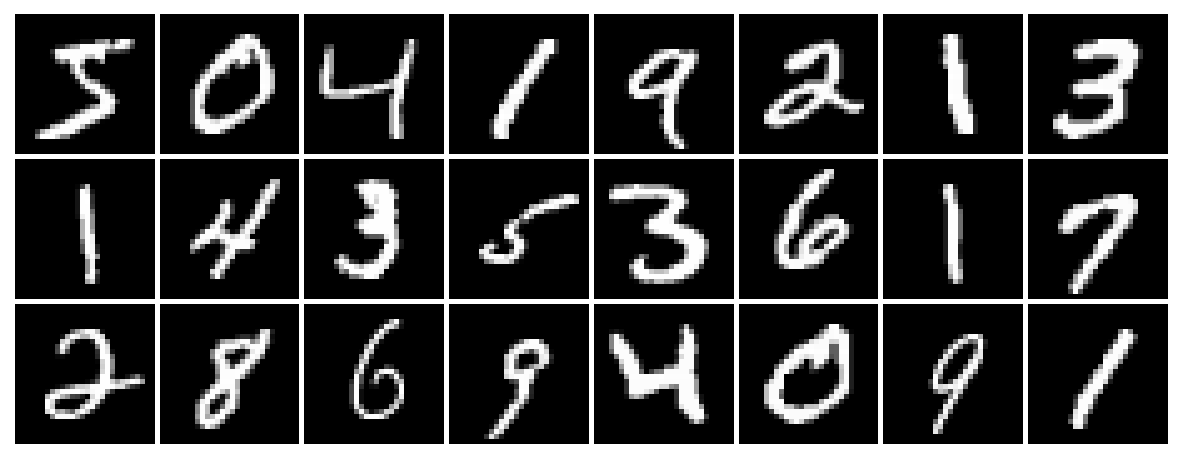

In [31]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(dim=1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(5)


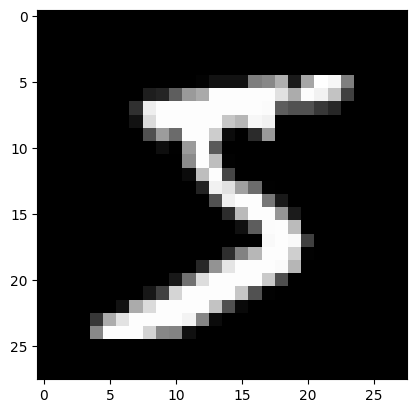

In [32]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy(), cmap='gray')
print('class:', target)

## Modelo

In [33]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

### Testando um predict com poucas amostras

In [34]:
xin = x_train[:5].view(-1,28*28)
score = model(Variable(xin))
score

tensor([[-0.2486, -0.2452,  0.1288, -0.2585, -0.1952, -0.0454,  0.1531, -0.0842,
         -0.0493,  0.0033],
        [-0.0105, -0.0475, -0.0799, -0.2129,  0.0389, -0.1698,  0.1839, -0.0450,
         -0.1777,  0.0102],
        [ 0.1760,  0.1657, -0.2037, -0.1643, -0.1070, -0.0356, -0.0566,  0.2435,
          0.0439,  0.1246],
        [-0.0123, -0.1751, -0.1322, -0.1721, -0.1380,  0.1446,  0.1611,  0.1609,
          0.0040,  0.0203],
        [-0.0999, -0.4930, -0.0378, -0.1500, -0.0405, -0.3056,  0.2944,  0.1535,
         -0.0769, -0.0613]], grad_fn=<AddmmBackward0>)

## Treinamento

### Inicialização dos parâmetros

In [35]:
epochs = 100
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

In [36]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-emvvoy52
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-emvvoy52
  Resolved https://github.com/szagoruyko/pytorchviz to commit 5cf04c13e601366f6b9cf5939b5af5144d55b887
  Preparing metadata (setup.py) ... done


In [37]:
from torchviz import make_dot, make_dot_from_trace
y_pred = model(Variable(x_train.view(-1,28*28)))
loss = criterion(y_pred, Variable(y_train))
loss


tensor(2.3099, grad_fn=<NllLossBackward0>)

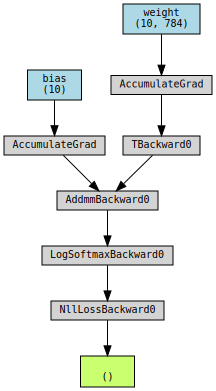

In [38]:
p = make_dot(loss, dict(model.named_parameters()))
p

### Laço de treinamento dos pesos

In [39]:
import numpy
losses = []
zs = []
acc_list = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()
    acc_list.append(accuracy)

In [40]:
print('Final loss:', loss.item())

Final loss: 0.3936530649662018


### Visualizando gráfico de perda durante o treinamento

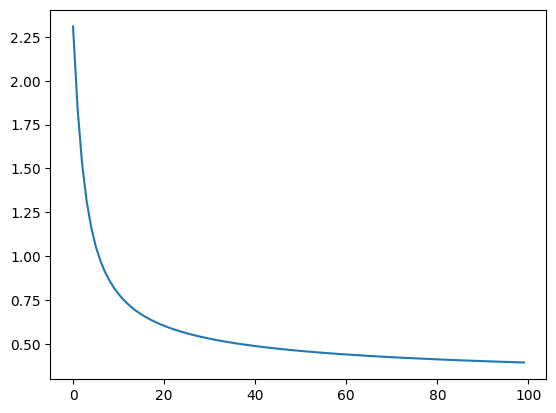

In [41]:
plt.plot(losses)

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [42]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)

    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.89465


### Matriz de confusão com dados de treinamento e teste

In [43]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,5683,1,56,32,11,110,46,50,33,48
1,0,6511,80,42,35,68,31,94,181,38
2,25,34,5099,159,42,47,66,103,81,42
3,20,27,98,5285,4,242,5,24,182,102
4,13,5,126,7,5313,88,51,82,28,235
5,45,47,17,264,6,4403,89,10,176,41
6,58,10,132,44,71,109,5569,3,43,4
7,4,15,129,80,15,31,2,5661,36,198
8,67,81,178,139,51,228,57,19,4975,61


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


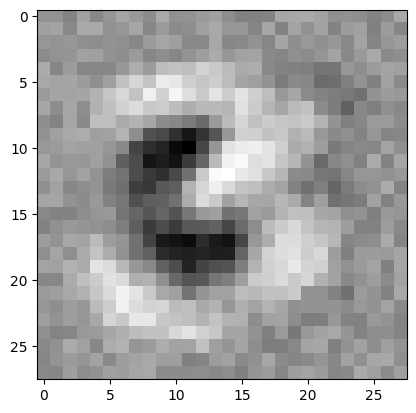

In [44]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

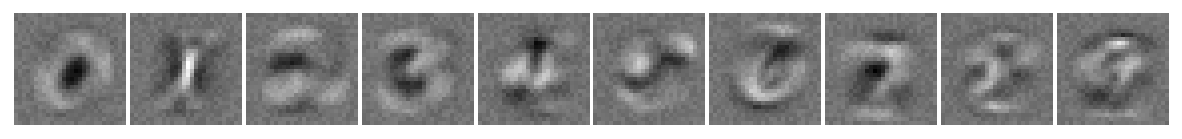

In [45]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmaxArgmaxNMIST.png)

# Atividades

## Exercícios

- 1) Insira código no laço do treinamento para que no final de cada época,
     seja impresso: o número da época e a perda e a acurácia

In [46]:
for i in range(epochs):

 print('Epoch[{}/{}], loss: {:.6f}, acc: {:.6f}'.format(i+1, epochs, losses[i], acc_list[i]))

Epoch[1/100], loss: 2.309871, acc: 0.099633
Epoch[2/100], loss: 1.842108, acc: 0.561600
Epoch[3/100], loss: 1.526203, acc: 0.739450
Epoch[4/100], loss: 1.311759, acc: 0.757017
Epoch[5/100], loss: 1.163735, acc: 0.793217
Epoch[6/100], loss: 1.055062, acc: 0.797867
Epoch[7/100], loss: 0.975007, acc: 0.814417
Epoch[8/100], loss: 0.911243, acc: 0.818267
Epoch[9/100], loss: 0.861429, acc: 0.826100
Epoch[10/100], loss: 0.818895, acc: 0.831817
Epoch[11/100], loss: 0.784094, acc: 0.835617
Epoch[12/100], loss: 0.753718, acc: 0.840533
Epoch[13/100], loss: 0.727937, acc: 0.843550
Epoch[14/100], loss: 0.705307, acc: 0.847133
Epoch[15/100], loss: 0.685534, acc: 0.848817
Epoch[16/100], loss: 0.667976, acc: 0.851700
Epoch[17/100], loss: 0.652297, acc: 0.853900
Epoch[18/100], loss: 0.638166, acc: 0.855850
Epoch[19/100], loss: 0.625348, acc: 0.857417
Epoch[20/100], loss: 0.613650, acc: 0.858917
Epoch[21/100], loss: 0.602920, acc: 0.860000
Epoch[22/100], loss: 0.593033, acc: 0.861517
Epoch[23/100], loss

- 2) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

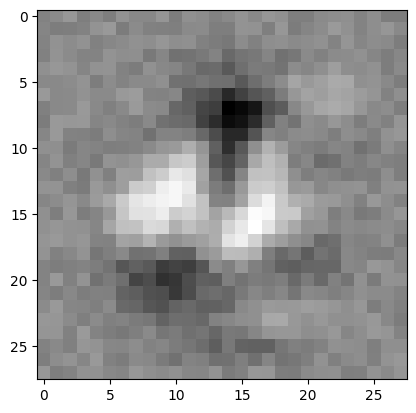

In [47]:
# Visualizando pesos da classe 3 -  numero 4
plt.imshow(weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

<details>
<summary>Mostrar Resultado</summary>

```python
losses = []
import numpy

import numpy
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)
    
    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    
    _, predicts = torch.max(outputs, 1)
    
    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()
    
    print('Epoch[{}/{}], loss: {:.6f}, acc: {:.6f}'
              .format(i+1, epochs, loss.data, accuracy))
    
    weights = model.state_dict()['weight']
    print('weights:', weights.shape)

    bias = model.state_dict()['bias']
    print('bias:   ', bias.shape)

    # Visualizando pesos da classe 3
    plt.imshow(weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
    plt.show()
```

</details>

## Perguntas

1. Qual é o shape da matriz de entrada na rede?
R - 28*28 matriz
2. Qual é o shape da saída da rede?
R - Número de Classes: 10 (para os dígitos de 0 a 9)
3. Qual é o número total de parâmetros da rede, incluindo o bias?
784 (28*28 ) + 10 (classes de saidas) + 10 (bias) = 7850 parametros valores de w


# Aprendizados
